In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,haha you guys are a bunch of losers.,0,1,0,0,0,1
1,ur a sh*tty comment.,0,0,1,0,0,1
2,It's ridiculous that these guys are being call...,0,1,0,0,0,1
3,Yet call out all Muslims for the acts of a few...,1,1,0,0,0,1
4,This bitch is nuts. Who would read a book by a...,0,1,1,0,0,1


In [4]:
data.shape

(337144, 7)

In [5]:
target = ['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic']

**Target Class Distribution**

In [6]:
data['positive'] = data[target].progress_apply(lambda row: 1-row.max(), axis=1)

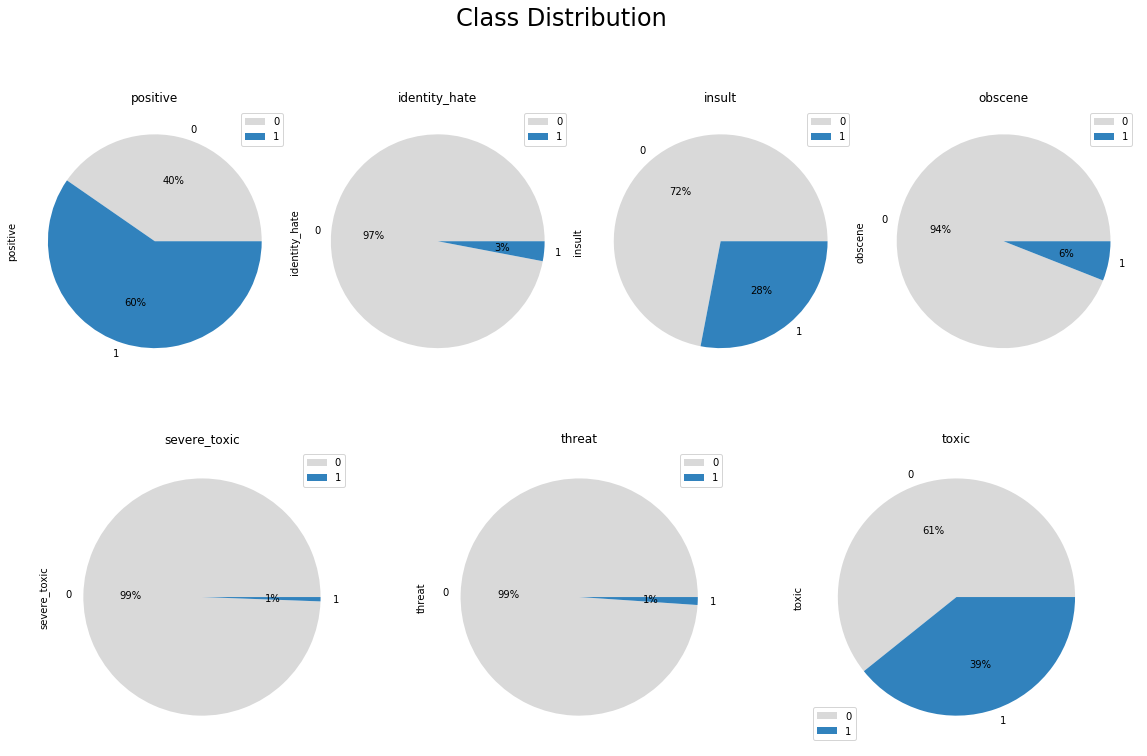

In [7]:
axes = []
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Class Distribution', fontsize=24)
for i in range(0, 12, 3):
    axes.append(plt.subplot2grid((2, 12), (0, i), colspan=3))
for i in range(0, 12, 4):
    axes.append(plt.subplot2grid((2, 12), (1, i), colspan=4))

for i, col in enumerate(['positive']+target):
    data[col].value_counts().sort_index().plot.pie(ax=axes[i], title=col, legend=True, autopct='%1.0f%%', colormap='tab20c_r')

Text(0.5, 1.0, 'Correlation between Classes')

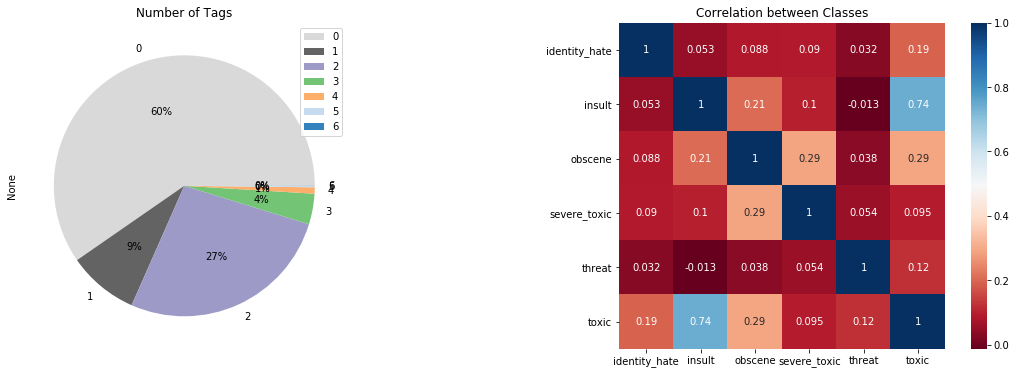

In [8]:
fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
data[target].sum(1).value_counts(normalize=True, sort=False).plot.pie(ax=ax[0], 
                                                legend=True, title='Number of Tags', colormap='tab20c_r',  autopct='%1.0f%%')
sns.heatmap(data[target].corr(), ax=ax[1], annot=True, cmap='RdBu', square=True)
ax[1].set_title('Correlation between Classes')

In [9]:
d_len = data['comment_text'].progress_apply(lambda x: len(x.split()))

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


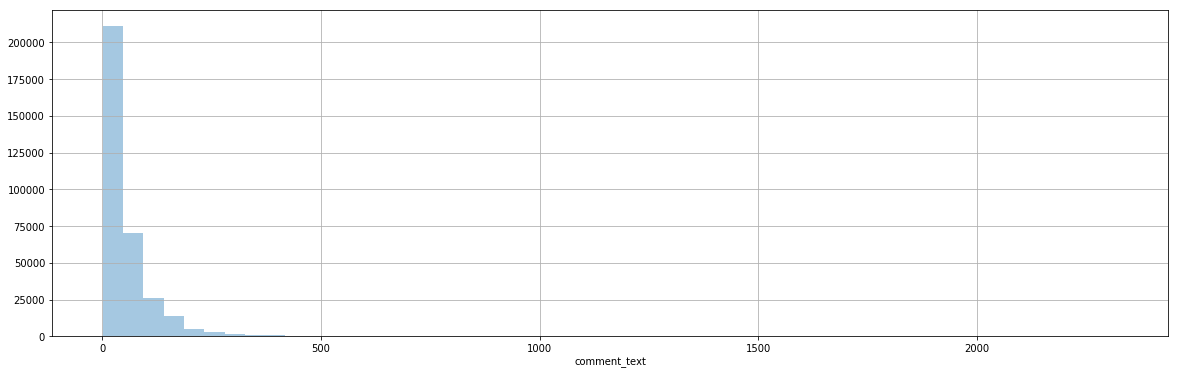

In [10]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.distplot(d_len, kde=False, norm_hist=False)
ax.grid()

In [11]:
def describe(data):
    min_ = data.min()
    q1 = data.quantile(0.01)
    q25 = data.quantile(0.25)
    q50 = data.quantile(0.50)
    q75 = data.quantile(0.75)
    q99 = data.quantile(0.99)
    max_ = data.max()
    return min_, q1, q25, q50, q75, q99, max_

In [12]:
distribution = pd.DataFrame({
    t : describe(d_len[data[t] == 1]) for t in ['positive']+target
}, index=['min', '1st', '25th', '50th', '75th', '99th', 'max'])
distribution['all'] =  describe(d_len)
distribution.transpose()

,min,1st,25th,50th,75th,99th,max
positive,1.0,4.0,17.0,37.0,77.0,565.00,1990.0
identity_hate,1.0,4.0,15.0,28.0,55.0,195.00,1247.0
insult,1.0,3.0,15.0,30.0,57.0,178.00,2321.0
obscene,1.0,3.0,11.0,23.0,48.0,496.59,2321.0
severe_toxic,2.0,4.0,9.0,18.0,45.0,971.65,1403.0
threat,1.0,3.0,10.0,16.0,30.0,182.00,1403.0
toxic,1.0,3.0,15.0,29.0,57.0,182.00,2321.0
all,1.0,3.0,16.0,34.0,68.0,459.00,2321.0


In [13]:
import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

def expand_contractions(text):
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"'s", " ", text)
    text = re.sub(r"'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"'re", " are ", text)
    text = re.sub(r"'d", " would ", text)
    text = re.sub(r"'ll", " will ", text)
    return text

def remove_url(text):
    URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\^`[\]]*)''')
    return URL_REGEX.sub(r' ', text)

def remove_handles(text):
    HANDLES_REGEX = re.compile(r'@\S+')
    return HANDLES_REGEX.sub(r' ', text)

remove_punc = lambda x : re.sub(r"\W", ' ', x)

remove_num = lambda x : re.sub(r"\d", ' ', x)

remove_extra_spaces = lambda x : re.sub(r"\s+", ' ', x)

remove_shortwords = lambda x: ' '.join(word for word in x.split() if len(word) > 2)

lower_case = lambda x : x.lower()

with open('stopwords.txt') as f:
    sw = map(lambda x : x.strip(), f.readlines())
stop_words = set(nltk.corpus.stopwords.words('english'))|set(sw)
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stop_words)

ps = PorterStemmer()
ps_stem = lambda x: ' '.join(ps.stem(word) for word in x.split())

wnl = WordNetLemmatizer()
wnl_lemmatize = lambda x: ' '.join(wnl.lemmatize(word) for word in x.split())

def tag_pos(x):
    tag_list =  nltk.pos_tag(nltk.word_tokenize(x))
    pos = ""
    for t in tag_list:
        pos += t[0] +'(' + t[1] +')' + ' '
    return pos

def cleanText(x, rsw, stm, lem, tgps):
    x = str(x)
    x = remove_url(x)
    x = lower_case(x)
    x = expand_contractions(x)
    x = remove_punc(x)
    x = remove_num(x)
    x = remove_extra_spaces(x)
    x = remove_shortwords(x)
    
    if rsw:
        x = remove_stopwords(x)
    if stm:
        x = ps_stem(x)
    if lem:
        x = wnl_lemmatize(x)
    if tgps:
        x = tag_pos(x)
    return x

In [14]:
data['clean_text'] = data['comment_text'].progress_apply(lambda x: cleanText(x, True, False, False, False))

In [15]:
from wordcloud import WordCloud

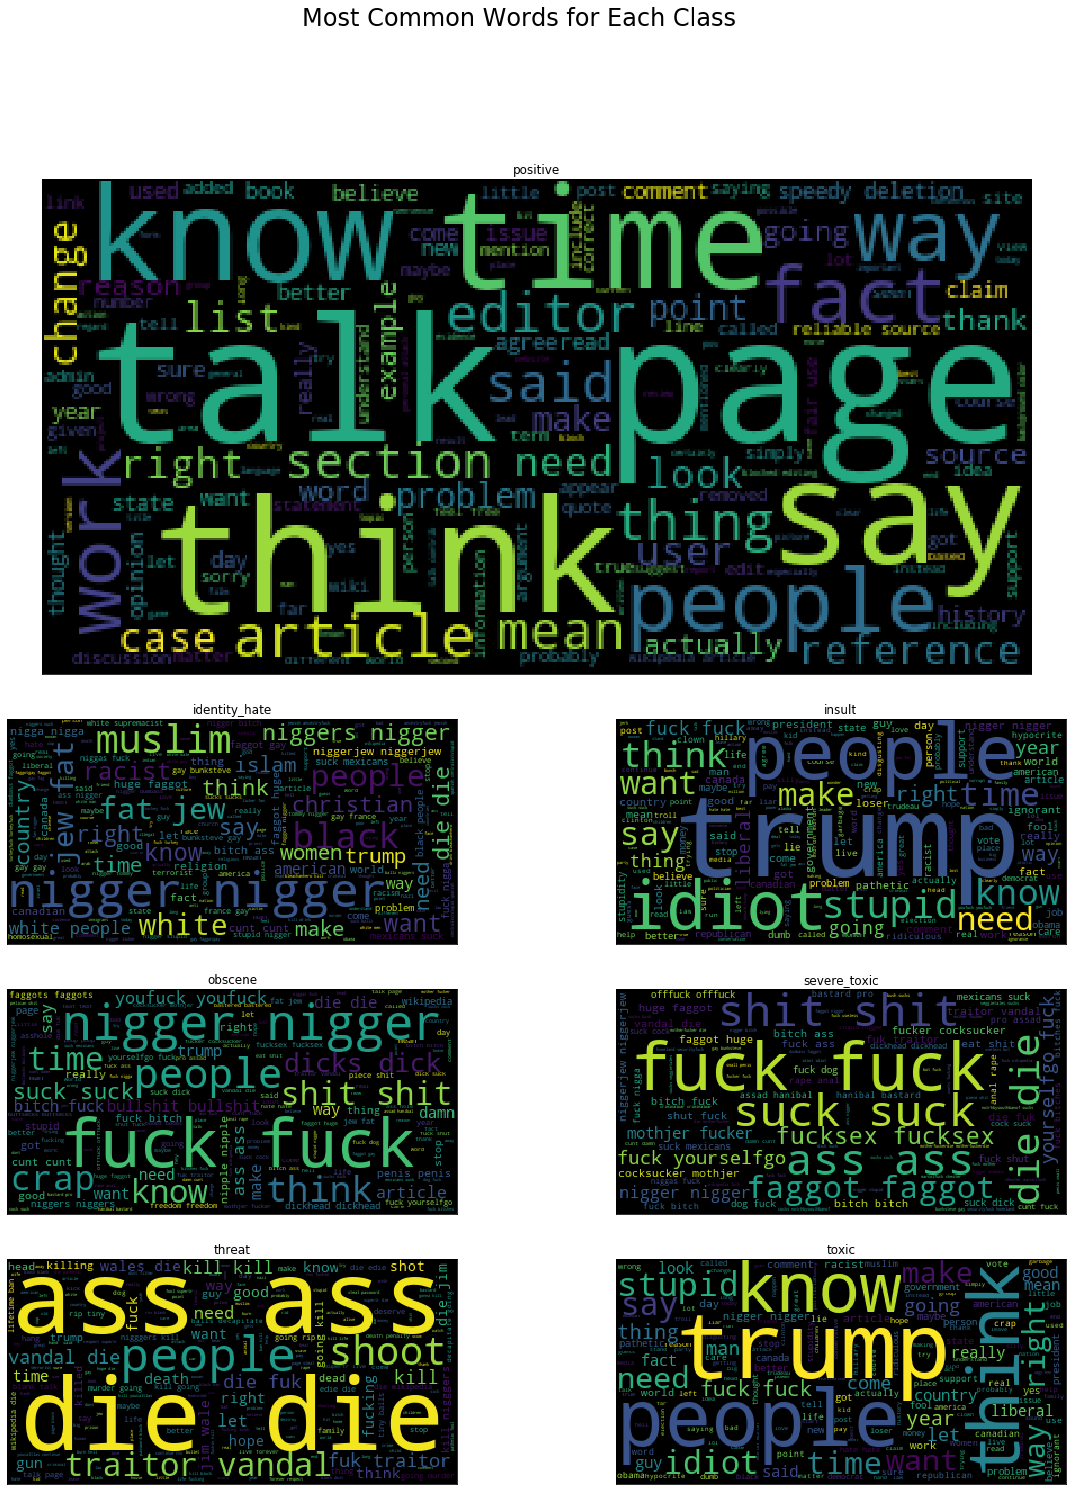

In [16]:
axes = []
fig = plt.figure(figsize=(20, 24))
fig.suptitle('Most Common Words for Each Class', fontsize=24)
axes.append(plt.subplot2grid((5, 2), (0, 0), colspan=2, rowspan=2))
for i in range(6):
    axes.append(plt.subplot2grid((5, 2), (i//2+2, i%2)))
    
for i, col in enumerate((['positive']+target)):
    axes[i].imshow(WordCloud().generate_from_text(' '.join(data[data[col] == 1]['clean_text'].values)))
    axes[i].set_title(col)
    axes[i].xaxis.set_visible(False)
    axes[i].yaxis.set_visible(False)
    
plt.savefig('WordCloud.png')    

**There are still some stop words that do not make any sense for determining the sentiment and also they occur in huge numbers so TFIDF wil be required to penalize them using IDF**

In [17]:
data.to_csv('data_cleaned.csv', index=False)